# Building the Multi-Task Model

### Reading in the X and Y semi-raw data

In [1]:
import numpy as np

In [2]:
X = np.load('data/x_data.npy')

In [3]:
Y = np.load('data/y_data.npy')

# Refactoring and Fine Filtering Data

In [4]:
tasks = {}

for x,y in zip(X,Y):
    if y in tasks:
        tasks[y]['data'].append(np.array(x[2:]))
        tasks[y]['target'].append(x[0])
    else:
        tasks[y] = {}
        tasks[y]['data'] = [np.array(x[2:])]
        tasks[y]['target'] = [x[0]]


In [5]:
print(tasks['CHEMBL664913']['target'])

[0.0, 1.0, 1.0, 1.0]


In [6]:
index = 1
top_targets = {}
for key, value in sorted(tasks.items(), key=lambda item: len(item[1]['target']), reverse=True):
    top_targets[key] = {}
    top_targets[key]['data'] = np.array(value['data'])
    top_targets[key]['target'] = np.array(value['target'])

    if index == 100:
        break
    index +=1 

### These are the top 100 targets that will be trained

In [7]:
print(list(top_targets))

['CHEMBL3436040', 'CHEMBL2114791', 'CHEMBL830839', 'CHEMBL828662', 'CHEMBL2114781', 'CHEMBL1071424', 'CHEMBL886170', 'CHEMBL3431931', 'CHEMBL665590', 'CHEMBL3063318', 'CHEMBL811879', 'CHEMBL1614549', 'CHEMBL831965', 'CHEMBL665702', 'CHEMBL1786290', 'CHEMBL1005407', 'CHEMBL882590', 'CHEMBL3562078', 'CHEMBL1614547', 'CHEMBL763870', 'CHEMBL680373', 'CHEMBL3110679', 'CHEMBL1061354', 'CHEMBL897494', 'CHEMBL3436039', 'CHEMBL827820', 'CHEMBL889609', 'CHEMBL2061832', 'CHEMBL1290876', 'CHEMBL692692', 'CHEMBL868999', 'CHEMBL1837593', 'CHEMBL1963965', 'CHEMBL665602', 'CHEMBL1047162', 'CHEMBL865064', 'CHEMBL1062971', 'CHEMBL963281', 'CHEMBL665700', 'CHEMBL934050', 'CHEMBL910725', 'CHEMBL769364', 'CHEMBL889241', 'CHEMBL681800', 'CHEMBL884350', 'CHEMBL873739', 'CHEMBL811068', 'CHEMBL852974', 'CHEMBL914035', 'CHEMBL1013888', 'CHEMBL1738498', 'CHEMBL909462', 'CHEMBL762914', 'CHEMBL3865048', 'CHEMBL893278', 'CHEMBL1101183', 'CHEMBL1073069', 'CHEMBL1027390', 'CHEMBL664911', 'CHEMBL1291622', 'CHEMBL91641

In [8]:
print(top_targets['CHEMBL3436040']['data'])

[[ 1.  0.  1. ...,  0.  1.  1.]
 [ 1.  0.  0. ...,  0.  0.  1.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  0. ...,  1.  1.  0.]
 [ 0.  0.  1. ...,  1.  0.  1.]]


In [9]:
from keras.layers import Input, Dense
from keras.models import Model
import time

inputs = Input(shape=(2048,))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()
print('Creating Sub Models:')
og_start = time.time()
index = 1
for x in top_targets.keys():
    start = time.time()
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    models_mtl[x] = model
    end = time.time()
    
    print("Model: ", index, " | Section Time: ", end - start, " | Elapsed Time: ", end - og_start)
    index += 1

Using TensorFlow backend.


Creating Sub Models:
Model:  1  | Section Time:  0.03954267501831055  | Elapsed Time:  0.03977155685424805
Model:  2  | Section Time:  0.03833723068237305  | Elapsed Time:  0.07825970649719238
Model:  3  | Section Time:  0.03869223594665527  | Elapsed Time:  0.11708593368530273
Model:  4  | Section Time:  0.03769207000732422  | Elapsed Time:  0.15548253059387207
Model:  5  | Section Time:  0.03921937942504883  | Elapsed Time:  0.19482779502868652
Model:  6  | Section Time:  0.03923511505126953  | Elapsed Time:  0.23420143127441406
Model:  7  | Section Time:  0.03904366493225098  | Elapsed Time:  0.2733798027038574
Model:  8  | Section Time:  0.03807473182678223  | Elapsed Time:  0.312241792678833
Model:  9  | Section Time:  0.1023719310760498  | Elapsed Time:  0.41473913192749023
Model:  10  | Section Time:  0.03952455520629883  | Elapsed Time:  0.4551379680633545
Model:  11  | Section Time:  0.039351463317871094  | Elapsed Time:  0.49464869499206543
Model:  12  | Section Time:  0.0386

Model:  99  | Section Time:  0.0397341251373291  | Elapsed Time:  4.186552047729492
Model:  100  | Section Time:  0.03919863700866699  | Elapsed Time:  4.225893020629883


## Creating the Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

#print(top_targets[x][0])

for x in top_targets.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(top_targets[x]['data'], 
                                                        top_targets[x]['target'], 
                                                        test_size=test_size, 
                                                        random_state=42)


In [11]:
%%time
EPOCHS = 20
from random import shuffle

all_keys = list(top_targets)
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        models_mtl[x].fit(X_train[x],y_train[x], verbose=0)

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, CPU times: user 2min 1s, sys: 4.76 s, total: 2min 6s
Wall time: 1min 57s


# Evaluating the Train-Test Split Data

In [12]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

CPU times: user 1min 8s, sys: 1.33 s, total: 1min 10s
Wall time: 1min 8s


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

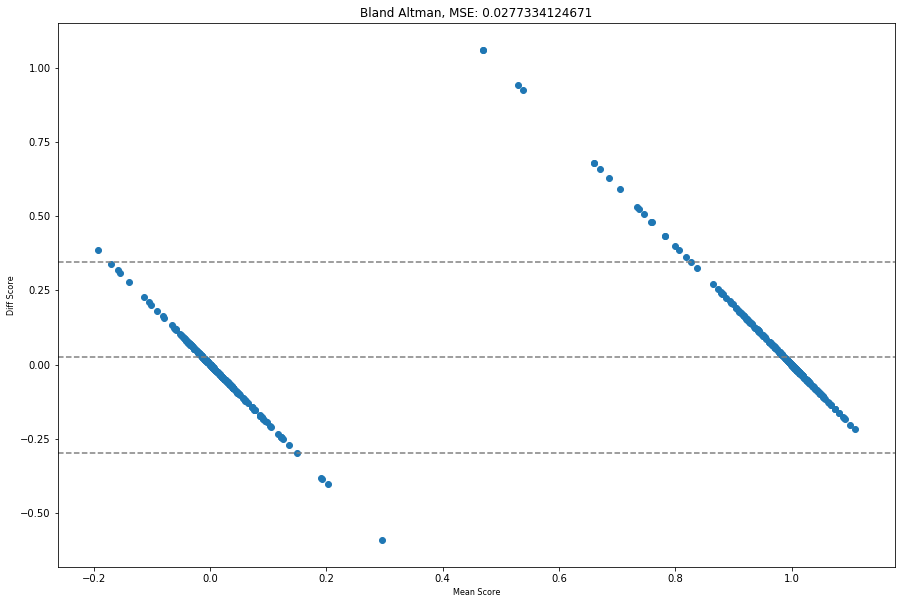

In [14]:

bland_altman_plot(np.concatenate(y_mtl), np.concatenate(yhat_mtl))